<a href="https://colab.research.google.com/github/LucasHenrique-dev/esteganografia-PDI/blob/imgbot/projeto_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def load_image(filename) :
  img = Image.open(filename)
  img_rgb = img.convert('RGB')
  data = np.array(img_rgb)
  return data

def show_image(npdata, gray = True):
  if gray:
    plt.imshow(npdata, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
  else:
    plt.imshow(npdata)
    plt.axis('off')
    plt.show()

def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

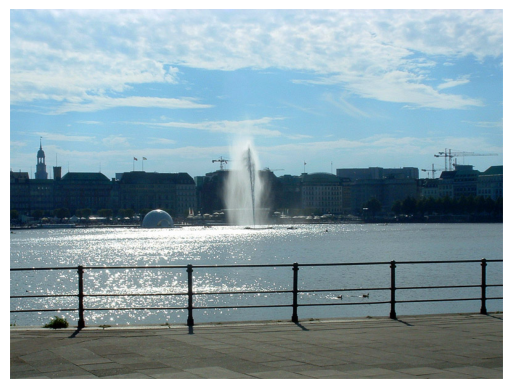

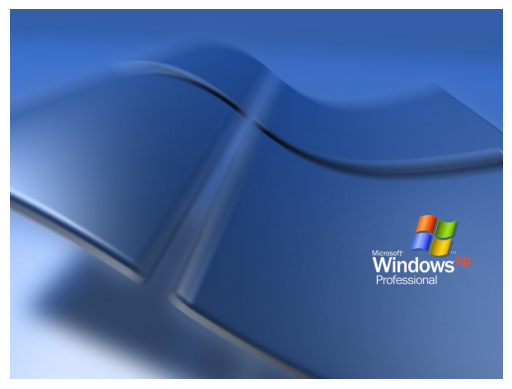

In [ ]:
img1 = load_image('img_1.jpg')
img2 = load_image('img_2.jpg')
show_image(img1)
show_image(img2)

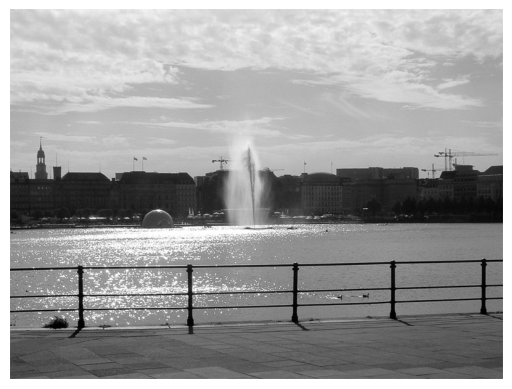

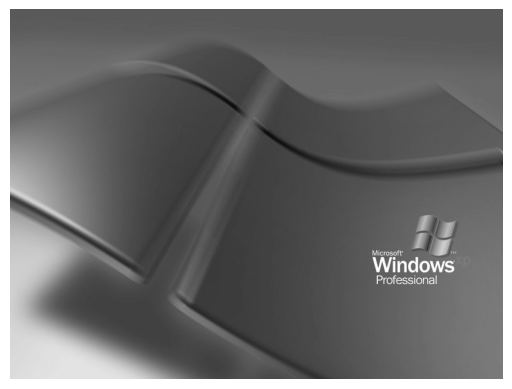

In [ ]:
img1_gray = rgb2gray(img1)
img2_gray = rgb2gray(img2)
show_image(img1_gray, gray = True)
show_image(img2_gray, gray = True)

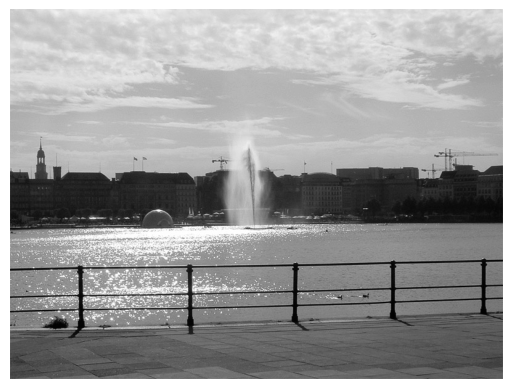

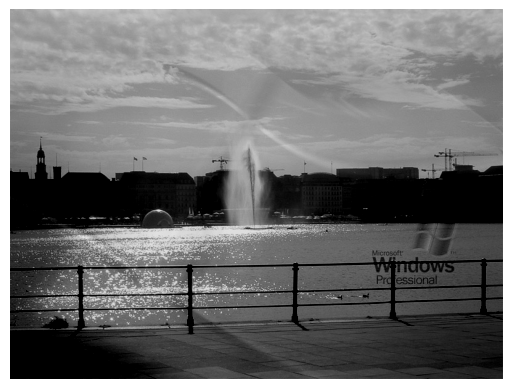

In [ ]:
img_together = np.zeros(img1_gray.shape)

ra = 2
img2_gray_copy = img2_gray/ra
img1_gray_copy = np.clip(img1_gray, 2.55, 255)

for e in range(len(img1_gray)):
  for f in range(len(img1_gray[0])):
    img_together[e][f] = img1_gray_copy[e][f] - (img2_gray_copy[e][f])

show_image(img1_gray_copy, gray = True)
show_image(img_together, gray = True)

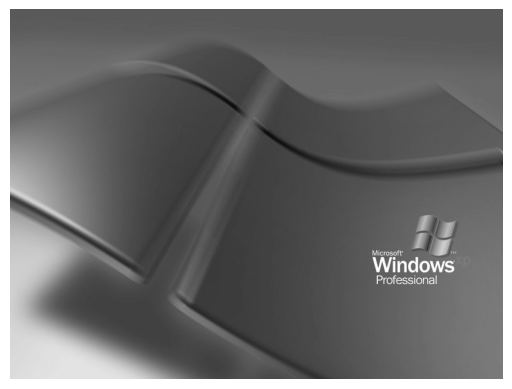

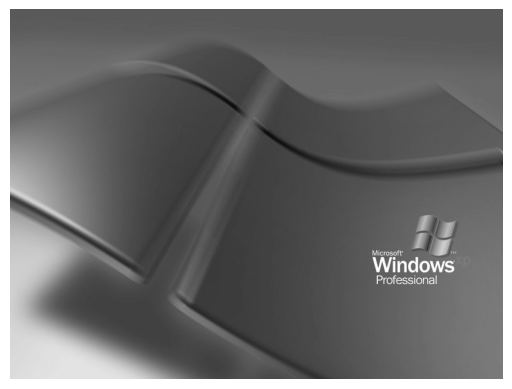

In [ ]:
img2_rescue = np.zeros(img1_gray.shape)

for e in range(len(img2_gray)):
  for f in range(len(img2_gray[0])):
    img2_rescue[e][f] = img1_gray_copy[e][f] - img_together[e][f]
    img2_rescue[e][f] = img2_rescue[e][f] * ra


show_image(img2_gray)
show_image(img2_rescue, gray = True)

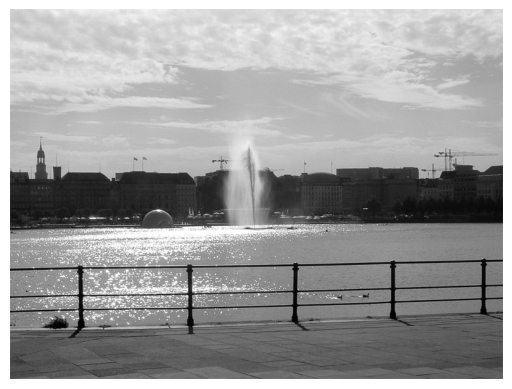

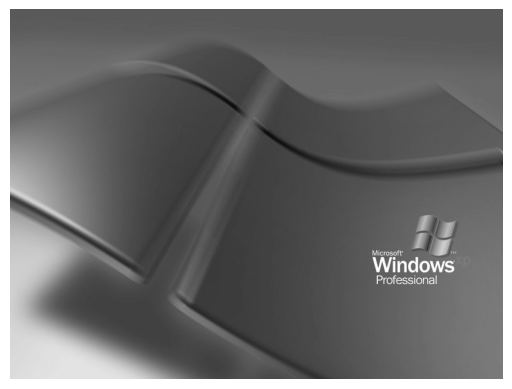

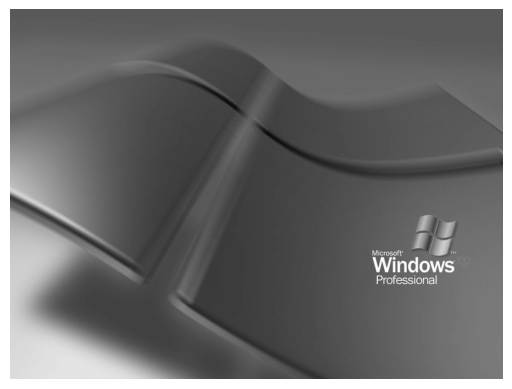

In [ ]:
def dct2(a):
    return cv2.dct(a.astype(np.float32))

def idct2(A):
    return cv2.idct(A)

def aumentar_contraste(imagem_array, fator_contraste):
    # Converter a imagem para o espaço de ponto flutuante para evitar overflow/underflow
    imagem_float = imagem_array.astype(np.float32)

    # Calcular o valor médio dos pixels
    media = np.mean(imagem_float, axis=(0, 1), keepdims=True)

    # Aumentar o contraste
    imagem_contraste = media + fator_contraste * (imagem_float - media)

    # Clampear os valores para o intervalo válido [0, 255]
    imagem_contraste = np.clip(imagem_contraste, 0, 255)

    # Converter de volta para o espaço de inteiros sem sinal
    return imagem_contraste.astype(np.uint8)

# Calcular a DCT das imagens
dct_img1 = dct2(img1_gray)
dct_img2 = dct2(img2_gray)

# Esconder img2 em img1 modificando os coeficientes DCT
alpha = 0.01 # fator de escala para inserção
dct_hidden = dct_img1 + alpha * dct_img2

# Calcular a IDCT para obter a imagem modificada
img_dct_hidden = idct2(dct_hidden)

# Mostrar imagem modificada
show_image(img_dct_hidden, gray=True)

# Recuperar a imagem escondida
dct_recovered = (dct_hidden - dct_img1) / alpha
img_dct_recovered = idct2(dct_recovered)

# Mostrar imagem recuperada
show_image(img2_gray, gray=True) # imagem original escondida
show_image(img_dct_recovered, gray=True) # imagem recuperada

In [ ]:
def compare_histograms(images, titles=[], gray=True):
  num_images = len(images)

  if num_images == 2:
      fig, axs = plt.subplots(1, 3, figsize=(20, 5))
      hist1, bins1 = np.histogram(images[0], bins=256, range=(0, 256))
      hist2, bins2 = np.histogram(images[1], bins=256, range=(0, 256))
      hist_diff = hist2 - hist1
      bin_centers = (bins1[:-1] + bins1[1:]) / 2
  elif num_images == 3:
      fig, axs = plt.subplots(1, 4, figsize=(15, 5))

  for i in range(num_images):
    if images[i].ndim == 2:  # Grayscale image
      sns.histplot(images[i].ravel(), bins=256, kde=True, color='gray', label='Grayscale', ax=axs[i])
    else:  # RGB image
      for j, color in enumerate(['r', 'g', 'b']):
        sns.histplot(images[i][:, :, j].ravel(), bins=256, kde=True, color=color, label=f'Channel {color.upper()}', ax=axs[i])

    # Definir o título da imagem, se fornecido
    if i < len(titles):
        axs[i].set_title(titles[i])

    #axs[i].axis('off')

  if num_images == 2:
    axs[2].bar(bin_centers, hist_diff, width=(bins1[1] - bins1[0]), color='green')
    axs[2].set_title('Difference in Histograms (Modified - Original)')
    axs[2].set_xlabel('Value')
    axs[2].set_ylabel('Difference in Count')
    axs[2].set_ylim([0, 50])

  # Mostrar a figura
  plt.show()

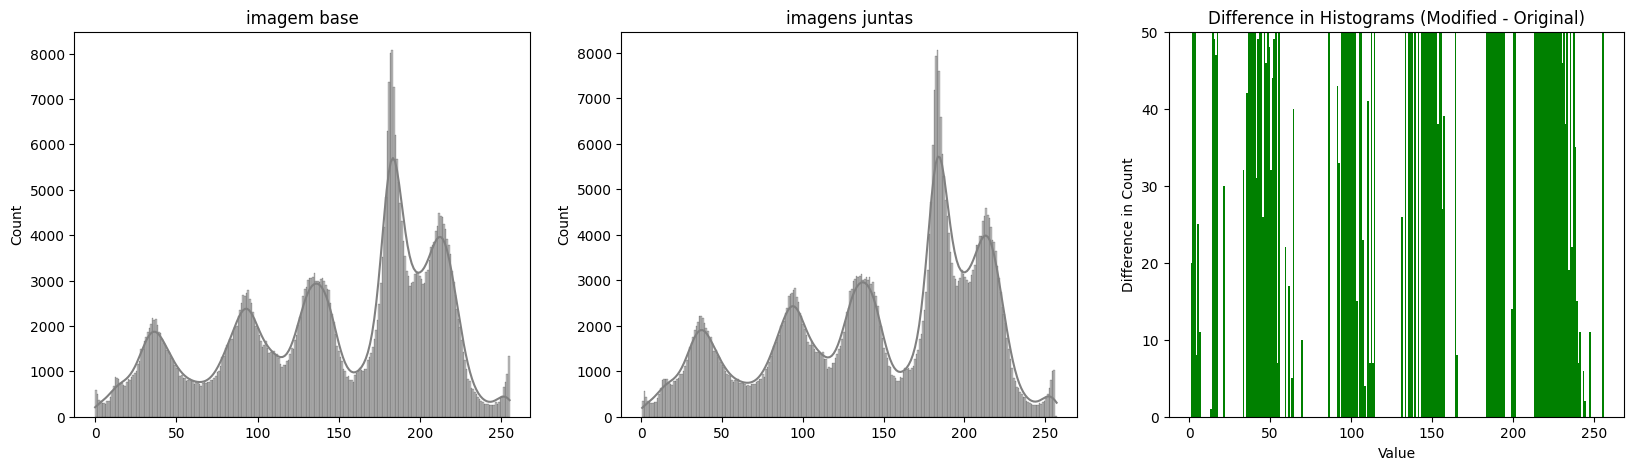

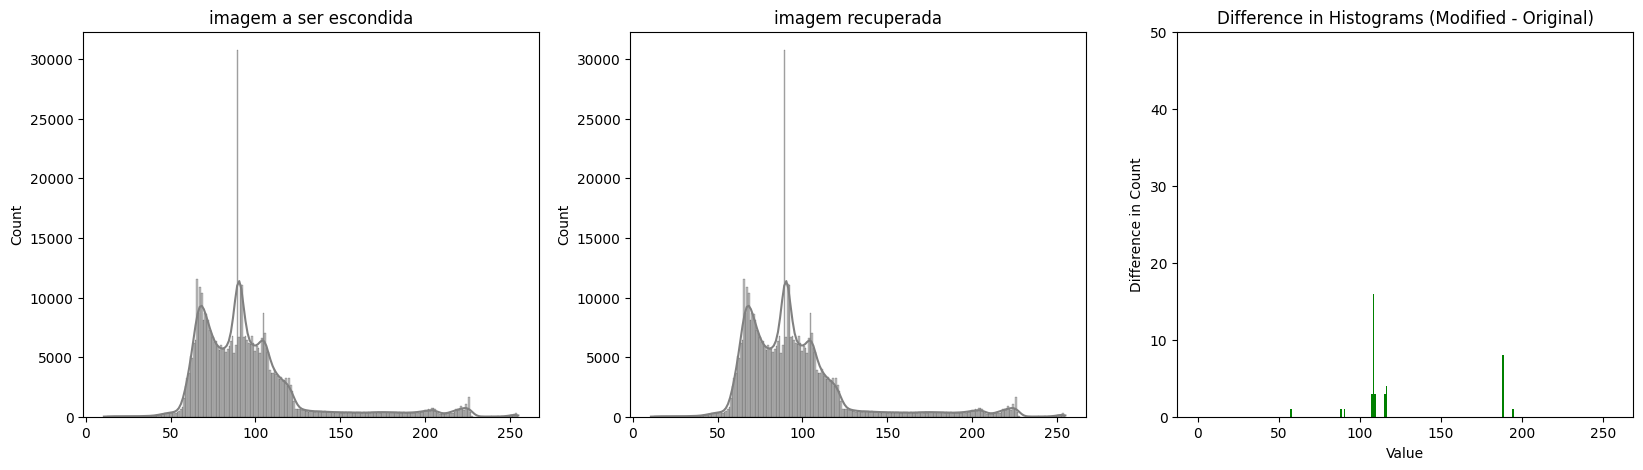

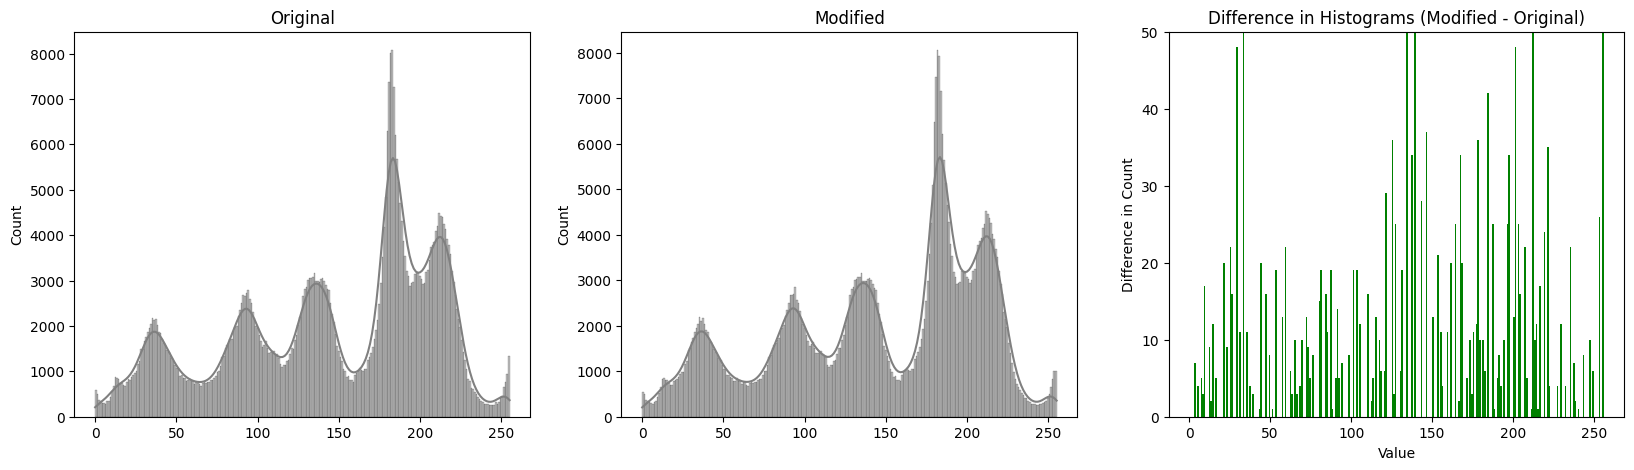

In [ ]:
compare_histograms([img1_gray, img_hidden], ['imagem base', 'imagens juntas'], gray=True)
compare_histograms([img2_gray, img_recovered], ['imagem a ser escondida', 'imagem recuperada'], gray=True)
compare_histograms([img1_gray, modified_image], ['Original', 'Modified'])

In [ ]:
def DCT_analysis_single(image, dct_image, contraste = 10):
  magnitude_spectrum = aumentar_contraste(dct_image, contraste)
  plt.figure(figsize=(12, 6))
  plt.subplot(121), plt.imshow(image, cmap='gray')
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
  plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

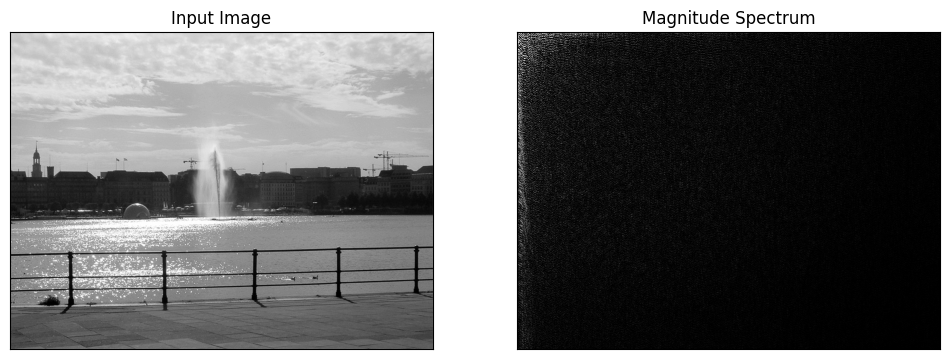

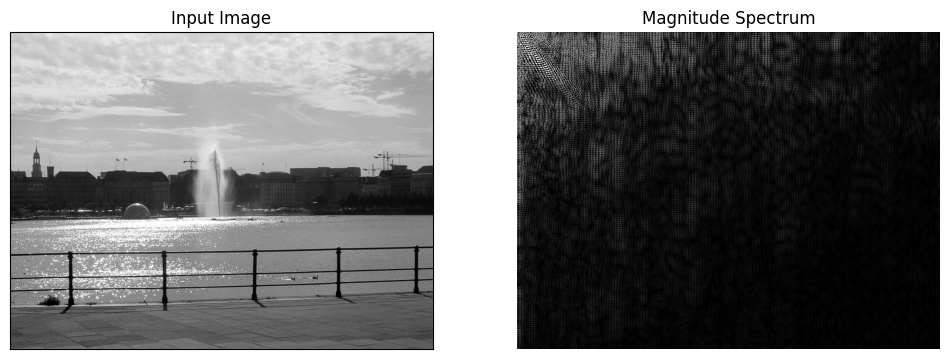

In [ ]:
dct_img1_gray = dct2(img1_gray)
dct_img_hidden = dct2(img_hidden)
DCT_analysis_single(img1_gray, dct_img1_gray, 2)
DCT_analysis_single(img_hidden, dct_img_hidden, 3)
show_image(aumentar_contraste(dct_img_hidden - dct_img1_gray, 1000))

In [ ]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def get_calculation_psnr_ssim(original, noisy):
  psnr_value = calculate_psnr(original, noisy)
  print(f'PSNR: {psnr_value} dB')

  # Calculate SSIM
  ssim_value, ssim_map = ssim(original, noisy, full=True)
  print(f'SSIM: {ssim_value}')

  # Display images and SSIM map
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 3, 1)
  plt.title('Original Image')
  plt.imshow(original, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title('Modified Image')
  plt.imshow(noisy, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('SSIM Map')
  plt.imshow(ssim_map, cmap='gray')
  plt.axis('off')

  plt.show()

PSNR: 47.95825279199214 dB
SSIM: 0.9997791116714922


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


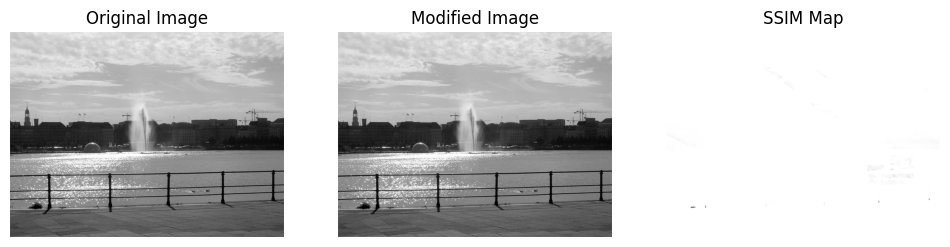

PSNR: 120.31195575513692 dB
SSIM: 0.9999999283772811


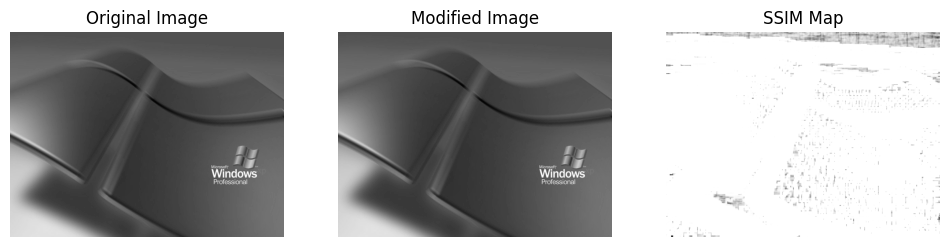

In [ ]:
get_calculation_psnr_ssim(img1_gray, img_hidden)
get_calculation_psnr_ssim(img2_gray, img_recovered)

In [ ]:
def message_to_bits(message):
    bits = ''.join([format(ord(char), '08b') for char in message])
    return [int(bit) for bit in bits]

def bits_to_message(bits):
    chars = []
    for b in range(len(bits) // 8):
        byte = bits[b*8:(b+1)*8]
        byte = ''.join(map(str, byte))
        chars.append(chr(int(byte, 2)))
    return ''.join(chars)

def hide_message_in_image(gray_image, message, alpha=0.01):
    dct_image = dct2(gray_image)
    message_bits = message_to_bits(message)

    h, w = dct_image.shape
    flat_dct = dct_image.flatten()
    flat_dct_new = dct_image.flatten()

    # Start hiding message bits from a higher frequency region
    start_index = (h * w) // 2
    for i in range(len(message_bits)):
        if start_index + i < len(flat_dct):
            flat_dct_new[start_index + i] = flat_dct[start_index + i] + alpha * message_bits[i]

    modified_dct = flat_dct_new.reshape(dct_image.shape)
    modified_image = idct2(modified_dct)

    return modified_image, flat_dct, flat_dct_new

def recover_message_from_image(flat_dct, flat_dct_new, alpha=0.01, message_length=32):
    # Start recovering message bits from a higher frequency region
    start_index = len(flat_dct) // 2

    message_bits = []
    for i in range(message_length * 8):
        if start_index + i < len(flat_dct):
            bit = (flat_dct_new[start_index + i] - flat_dct[start_index + i]) / alpha
            bit = int(round(bit))
            if bit < 0:
                bit = 0
            elif bit > 1:
                bit = 1
            message_bits.append(bit)

    recovered_message = bits_to_message(message_bits)

    return recovered_message

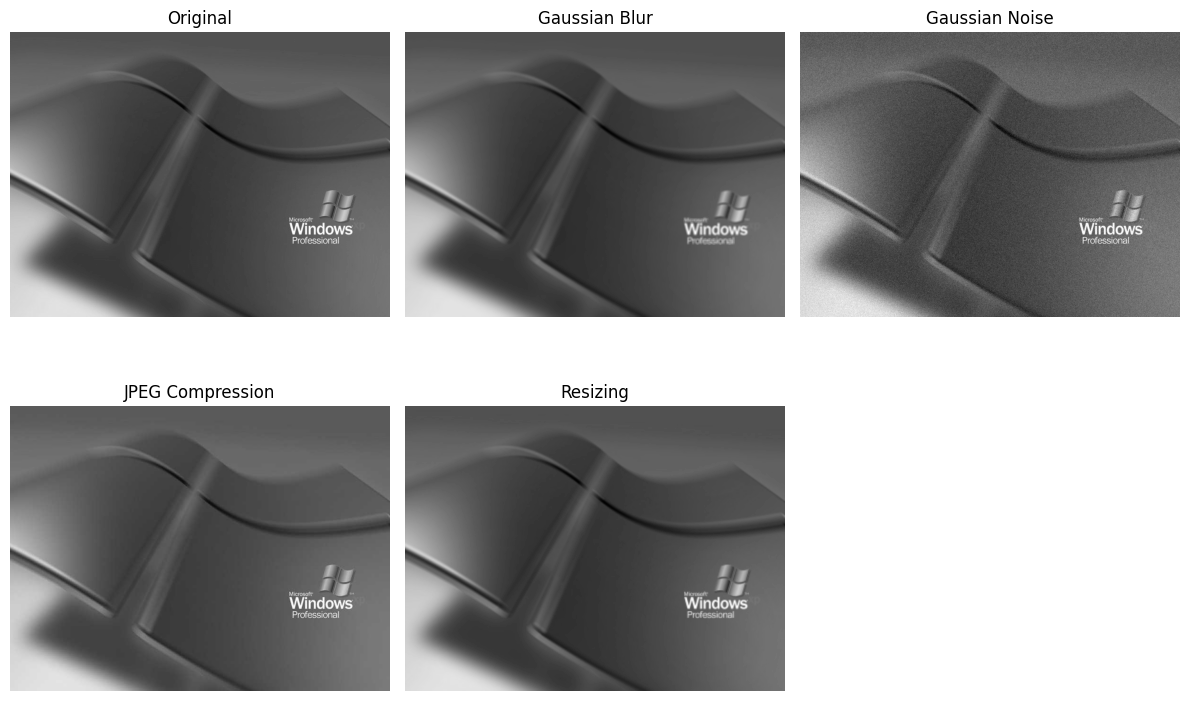

In [ ]:
# Função para aplicar diferentes filtros

def apply_filters(image):
    filters = {}

    # 1. Filtro de Desfoque (Blur)
    blur = cv2.GaussianBlur(image, (5, 5), 10)
    filters['Gaussian Blur'] = blur

    # 2. Filtro de Ruído (Adicionar Ruído Gaussiano)
    row, col = image.shape
    mean = 0
    sigma = 10
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    filters['Gaussian Noise'] = noisy

    # 3. Filtro de Compressão JPEG
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 50]  # qualidade de 50%
    result, encimg = cv2.imencode('.jpg', image, encode_param)
    jpeg = cv2.imdecode(encimg, 1)
    filters['JPEG Compression'] = jpeg


    # 5. Filtro de Redimensionamento
    resized = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))
    resized = cv2.resize(resized, (image.shape[1], image.shape[0]))
    filters['Resizing'] = resized

    return filters

# Carregar a imagem original
image_path = 'img_2.jpg'
original_image = rgb2gray(load_image(image_path))

# Mensagem a ser ocultada
mensage = "Hello, this is a secretAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"

# Esconder a mensagem na imagem
hide_image, flt_dct, flt_dct_new = hide_message_in_image(original_image, mensage, alpha=5)
dct_original = dct2(original_image)
dct_hide = dct2(hide_image)

# Aplicar filtros
filtered_images2 = apply_filters(original_image)
filtered_images = apply_filters(hide_image)

# Exibir as imagens originais e filtradas
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(hide_image, cmap='gray')
plt.title('Original')
plt.axis('off')

for i, (filter_name, filtered_image) in enumerate(filtered_images.items(), start=2):
    plt.subplot(2, 3, i)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(filter_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
for i in filtered_images:
  print(i)
  mensagem = recover_message_from_image(dct_original.flatten(), dct2(filtered_images[i].flatten()).flatten(), alpha=0.01, message_length=len(mensage))
  print("Recovered message:", mensagem)

Gaussian Blur
Recovered message: )Ì­´­%©Õ+KJÖËkRªõ­K])KJÖ¥)­jm	J­jU+[+QkZÖ¥kJÖ¤µªV­JZZÖÒZRÕjÕZµÔ«WÒ¥Zµ)Z©R«UªkZ+]iJU+)kZµ­jµ©
Gaussian Noise
Recovered message: ²ÒkJjKùt--+XpÂ£3³-KsFrMJA9,58DÂË²Ð^´¶¶Ô;Cÿ¸Zfù'Â¶!JHf6±·
ém±½OrÝMÌo«JIÍ9@º14Î{µ)
JPEG Compression
Recovered message: ºÒÚZJKim--m¥m¤¤¡¶«J[KJKT¶ÚIJKKI-km-´»RJZÖiJÒIµ¤´«V«KKZ¤´ÖZ[J¥å­%¤µZ¥¤´VÚ[KK%)%¤ÚIfÚRIJµ)
Resizing
Recovered message: ªÊ©I)-i¤µ­õ«IJÓm+Zªµ©ku)KZÖ¥+-jMIK­jU+[+SkZÖ¥kJÖ¤µªV­JZZÖÒZRÕjÕZÔ«WÒ¥Zµ)Z©R«UªiZ+UiJU+)kZµ­jµ©


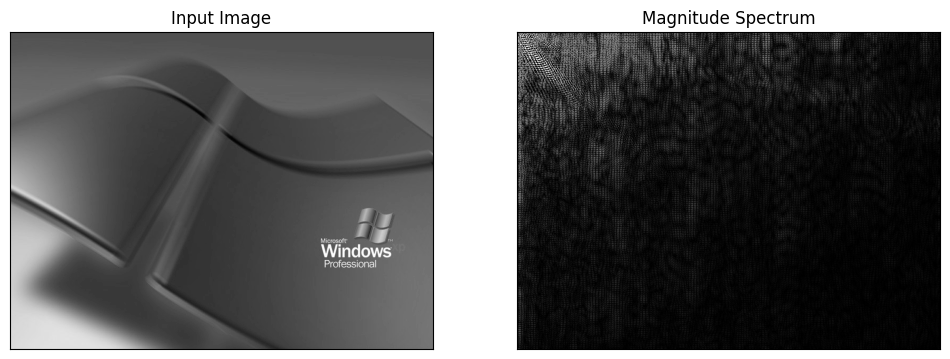

In [ ]:
DCT_analysis_single(original_image, dct_original, 10)

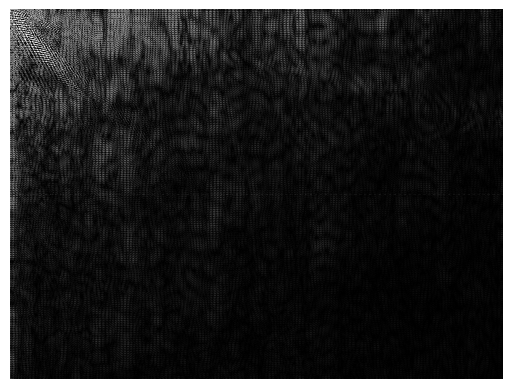

In [ ]:
enhancer = aumentar_contraste(dct_hide, fator_contraste = 10)
show_image(enhancer)

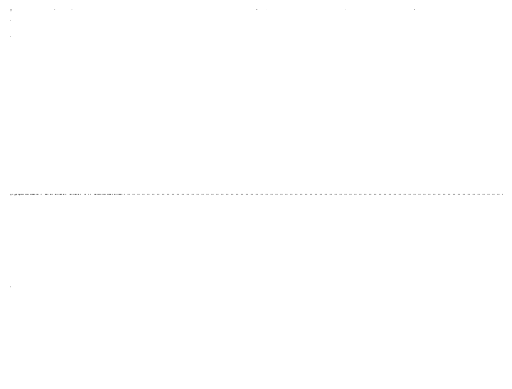

In [ ]:

enhancer = aumentar_contraste((dct_original - dct_hide), fator_contraste = 250000)
show_image(enhancer)

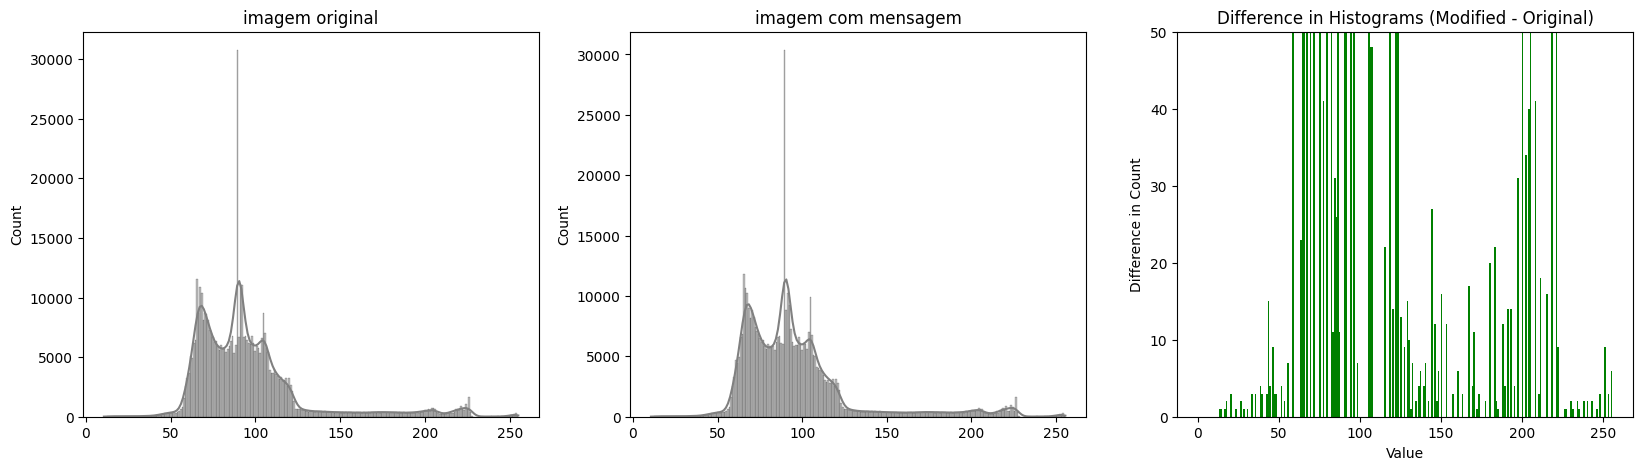

In [ ]:
compare_histograms([original_image, hide_image], ['imagem original', 'imagem com mensagem'], gray=True)